In [1]:
from langchain_ollama.llms import OllamaLLM
import json
from urllib.parse import quote_plus
from langchain_community.utilities import SQLDatabase
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool
from typing_extensions import Annotated
import re
from langchain_core.prompts import ChatPromptTemplate
from typing_extensions import TypedDict
from langgraph.graph import START, StateGraph
from datetime import date
import os
from langchain.chat_models import init_chat_model


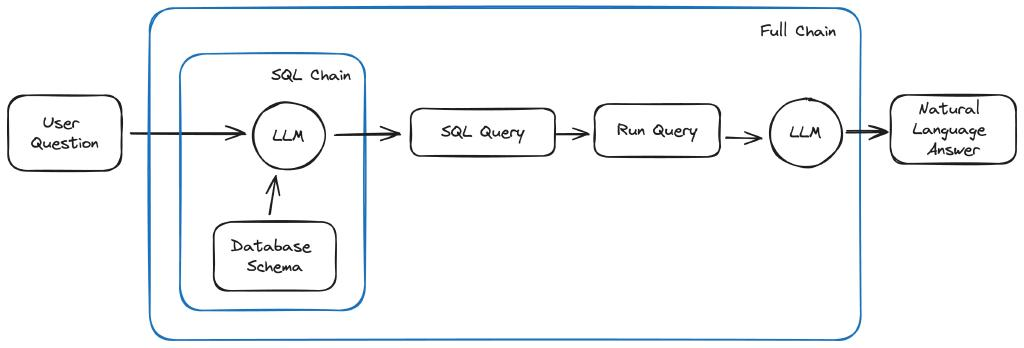

https://python.langchain.com/docs/tutorials/sql_qa/

In [2]:
# Load secrets
with open("secrets.json") as f:
    secrets = json.load(f)

# URL-encode the password and other components
username = quote_plus(secrets["username"])
password = quote_plus(secrets["password"])
server = secrets["server"]
database = secrets["database"]

# ODBC driver name (make sure it's installed)
driver = "ODBC Driver 18 for SQL Server"

# Build connection string
connection_uri = (
    f"mssql+pyodbc://{username}:{password}@{server}/{database}"
    f"?driver={driver.replace(' ', '+')}&Encrypt=no&TrustServerCertificate=yes"
)

# Connect using LangChain
db = SQLDatabase.from_uri(connection_uri, include_tables=["Intern25AlanChen"],  view_support=True) # test with a specific table

# Test
print(db.dialect)
print(db.get_usable_table_names())
# print(db.run("SELECT TOP 5 * FROM OrderEntry"))  


mssql
['Intern25AlanChen']


In [3]:
## local llm
# llm = OllamaLLM(model="mistral",  model_kwargs={"temperature": 0})

## test
# for chunk in llm.stream("What is the capital of France?"):
#     print(chunk, end="", flush=True)# checked, works well

In [4]:
#  Gemni API
os.environ["GOOGLE_API_KEY"] = secrets["GoogleApiKey"]

llm = init_chat_model("gemini-2.0-flash", model_provider="google_genai")

# test
# for chunk in llm.stream("What is the capital of France?"):
#     print(chunk.content, end="", flush=True)  ## The capital of France is **Paris**.

c:\Users\AlanC\anaconda3\envs\LangChainSQL\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# what we care:
```
    ->where('OrderEntry.Cancel', '=', '0')
    ->where('OrderEntry.Shipping', '=', '0');
    
// Apply conditional filters based on $type
if ($status_type === 'to-be-completed') {
    $machinesData->where('OrderEntry.ProdFinished', '=', 0);
} elseif ($status_type === 'awaiting-packing') {
    $machinesData
        ->where('OrderEntry.ProdFinished', '=', 1)
        ->where('OrderEntry.NeedPack', '=', 1)
        ->where('OrderEntry.ProdSupportFinish', '=', 0);
} elseif ($status_type === 'done') {
    $machinesData->where(function ($query) {
        $query->where(function ($q) {
            $q->where('OrderEntry.NeedPack', '=', 0)
            ->where('OrderEntry.ProdFinished', '=', 1);
        })->orWhere(function ($q) {
            $q->where('OrderEntry.NeedPack', '=', 1)
            ->where('OrderEntry.ProdSupportFinish', '=', 1);
        });
    });
```

In [5]:
# create a dictionary type for the state
class State(TypedDict): 
    question: str
    query: str
    result: str
    answer: str

In [6]:
system_message = """
You are a helper that writes Microsoft SQL Server queries. Follow these instructions exactly:

1. **Purpose**  
   - Generate a SQL Server query that answers the user's question.  
   - Do **not** include explanations, commentary, or any text other than the final SQL query.

2. **Placeholders**  
   - `{question}` - the user's natural-language question.  
   - `{table_info}` - a text description of the database schema (table and column names).  
   - `{today}` - the current date in SQL-Server format (e.g., `'2025-06-05'`).

3. **Schema Rules**  
   - Use T-SQL syntax.
   - Avoid joins; if all columns are needed, use `*`.
   - Use SQL Server functions for date calculations (e.g., `GETDATE()`, `DATEADD`).

4. **Business Logic**  
   - In the `OrderEntry` table:
   - ProdFinished: 
      - 0 before production is complete
      - 1 after production is complete
      - This is a dynamic status flag

   - NeedPack:
      - Always 1 if the order requires packing (regardless of status)
      - Always 0 if the order does not require packing
      - This is a constant / static indicator

   - ProdSupportFinish:
      - 0 before support team completes packing
      - 1 after packing is finished
      - This is a dynamic status flag

      Interpret the user's question by identifying references to specific business concepts. Apply filters based on the relevant column triggers below.

      1. **General Shipping Queries**
         - Applies when the question refers to all orders scheduled for shipment today.
         - Examples:
         - “How many orders are scheduled to ship today?”
         - “What are today's shipments?”
         - Filter:
         WHERE ShipDate = {today}

      2. **Imprinting Completed Queries (`ProdFinished = 1`)**
         - Applies when the question asks about orders with imprinting complete.
         - Examples:
         - “How many orders have imprinting finished today?”
         - “Orders with printing completed?”
         - Filter:
         WHERE ShipDate = {today}
            AND ProdFinished = 1

      3. **Packing Required Queries (`NeedPack = 1`)**
         - Applies when the question involves orders that require packing.
         - Examples:
         - “Which orders need to be packed today?”
         - “Orders that still need packing?”
         - Filter:
         WHERE ShipDate = {today}
            AND NeedPack = 1

      4. **Packing Completed Queries (`ProdSupportFinish = 1`)**
         - Applies when asking about orders that have been packed or completed.
         - Examples:
         - “How many orders are fully packed today?”
         - “How many orders are completed today?”
         - Filter:
         WHERE ShipDate = {today}
            AND ProdSupportFinish = 1

         - If the user is asking to list, show, find, or tell about **orders**, and is **not explicitly requesting specific columns or details**, return only the `OrderSplitID` column.
            - Applies for phrasing like: "which orders", "list orders", "what are the orders", "show me the orders", "tell me about the orders", "give me the completed orders", etc.
            - Only return `*` if the user explicitly asks for full details, specific fields, or says “show all details”.

      5. **Composite Conditions (Multiple Flags)**
         - If the user mentions combinations like “ready to be packed,” apply the appropriate logical AND of conditions.
         - Example:
         - “Orders ready to be packed” → must satisfy:
         - Filter:
         WHERE ShipDate = {today}
            AND ProdFinished = 1
            AND NeedPack = 1
            AND ProdSupportFinish = 0

         - For any question that implies identifying, listing, showing, or describing orders (e.g., “which orders”, “list orders”, “show orders”), return only `OrderSplitID`, unless specific columns or details are explicitly requested.

    **Instruction**  
      - Do **not** mix filters unless the user's language **explicitly** refers to them.  
      -> Only apply a column filter if the question clearly maps to its meaning.

      - The database only contains records from **today forward**.  
      -> If the user asks for past data (e.g., "yesterday", "last week", or "shipped"), you must return a query that will produce an **empty result set**.

      - If the user's question is vague, ambiguous, or does not match any known logic or column mapping, you must also return a query that produces an **empty result set**.

      - When in doubt, it is **better to return no data** than to return **incorrect or assumed data**.

5. **Formatting Requirements**  
   - Output only the SQL statement, starting with `SELECT` and ending with a semicolon.
   - Do **not** include code fences, comments, or extra text.

6. **Your Task**  
   Replace `{question}`, `{table_info}`, and `{today}` with the actual values when generating the query. Produce **only** the **raw** SQL query that answers `{question}`, using the rules above.

### SQL
Given the database schema, write the SQL query that answers:
`{question}`
"""

user_prompt = "Question: {input}"

query_prompt_template = ChatPromptTemplate(
    [("system", system_message), ("user", user_prompt)]
)

for message in query_prompt_template.messages:
    message.pretty_print()

================================ System Message ================================


You are a helper that writes Microsoft SQL Server queries. Follow these instructions exactly:

1. **Purpose**  
   - Generate a SQL Server query that answers the user's question.  
   - Do **not** include explanations, commentary, or any text other than the final SQL query.

2. **Placeholders**  
   - `{question}` - the user's natural-language question.  
   - `{table_info}` - a text description of the database schema (table and column names).  
   - `{today}` - the current date in SQL-Server format (e.g., `'2025-06-05'`).

3. **Schema Rules**  
   - Use T-SQL syntax.
   - Avoid joins; if all columns are needed, use `*`.
   - Use SQL Server functions for date calculations (e.g., `GETDATE()`, `DATEADD`).

4. **Business Logic**  
   - In the `OrderEntry` table:
   - ProdFinished: 
      - 0 before production is complete
      - 1 after production is complete
      - This is a dynamic status flag

   - Need

In [7]:
print(db.get_table_info())


CREATE TABLE [Intern25AlanChen] (
	[OrderID] INTEGER NULL, 
	[OrderSplitID] INTEGER NOT NULL IDENTITY, 
	[ProdFinished] BIT NOT NULL, 
	[NeedPack] BIT NOT NULL, 
	[ProdSupportFinish] BIT NOT NULL, 
	[ShipDate] DATETIME NULL
)

/*
3 rows from Intern25AlanChen table:
OrderID	OrderSplitID	ProdFinished	NeedPack	ProdSupportFinish	ShipDate
4859020	4756155	False	False	False	2025-07-22 00:00:00
4866413	4768776	False	False	False	2025-06-23 00:00:00
4881181	4779986	False	False	False	2025-06-20 00:00:00
*/


In [8]:
from pydantic import BaseModel, Field

class QueryOutput(BaseModel):
    query: str = Field(..., description="Syntactically valid SQL query.")



def write_query(state: State):
    """Generate SQL query to fetch information."""
    print("Generating SQL query...")
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect, # mssql for Ariel 
            "question": state["question"],
            "table_info": db.get_table_info(),
            "input": state["question"],
            "today": date.today().isoformat(),  # Use ISO format for today
        }
    )

    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query": result.query}


In [9]:
# test write query
# write_query({"question": "How many orders are scheduled to ship today?"}) ## {'query': "SELECT count(*) FROM Intern25AlanChen WHERE ShipDate = '2025-06-18';"}

In [10]:
def execute_query(state: State):
    """Execute SQL query."""
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])}

In [11]:
# test execute query
# execute_query({"query": "SELECT count(*) FROM Intern25AlanChen WHERE ShipDate = '2025-06-18';"}) ## {'result': '[(321,)]'}

In [12]:
# # test prompt
# prompt_question = "For OrderID = 180696, what is it's ShipDate?"
# # prompt_question= "Can you tell me about the orders which are completed these 10 days?"

# result_query = write_query({"question": prompt_question})
# # result_query = write_query({"question": })
# print(f"Generated query: {result_query}")

In [13]:
# result = execute_query({"query": result_query['query']})
# print(result)

# Generate Result

In [14]:
def generate_answer(state: State):
    """Answer question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f'User\'s Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
        "If the SQL result is empty, just answer 'I don't know'\n"
        "You don't need to explain the SQL query or result, just answer the question directly.\n\n"
        "Answer: "
    )
    response = llm.invoke(prompt)
    return {"answer": response.content.strip()}


In [15]:
# test generate answer
# generate_answer({"question": "How many orders are scheduled to ship today?",
#                  "query": "SELECT count(*) FROM Intern25AlanChen WHERE ShipDate = '2025-06-18';",
#                     'result': '[(321,)]'}) ## {'answer': '321'}

---
### Build Graph

In [16]:

graph_builder = StateGraph(State).add_sequence(
    [write_query, execute_query, generate_answer]
)
graph_builder.add_edge(START, "write_query")
graph = graph_builder.compile()

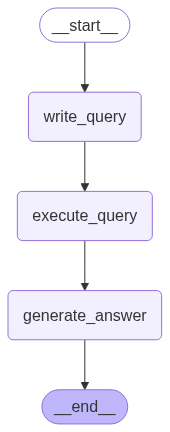

In [17]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
Question = "How many orders are scheduled to ship today?" # working

# for step in graph.stream(
#     {"question": Question}, stream_mode="updates"    
# ):
#     print(step)

result = graph.invoke({"question": "How many orders are scheduled to ship today?"})
print(result)

Generating SQL query...
{'question': 'How many orders are scheduled to ship today?', 'query': "SELECT count(*) FROM Intern25AlanChen WHERE ShipDate = '2025-06-19';", 'result': '[(151,)]', 'answer': '151'}


In [20]:
# write for loop to test all questions
questions = [
    "For OrderID = 180696, what is it's ShipDate?",
    "Can you tell me about the orders which are completed these 10 days?",
    "How many orders are scheduled to ship today?",
    "How many orders are scheduled to ship tomorrow?", 
    "今天有多少订单安排发货？",
    "How many orders are fully packed today?"
    ]
for question in questions:
    result = graph.invoke({"question": {question}})
    print(result["question"])
    print(result["query"])
    print(result["result"])
    print(result["answer"])
    print("-"*100)



Generating SQL query...
{"For OrderID = 180696, what is it's ShipDate?"}
SELECT ShipDate FROM Intern25AlanChen WHERE OrderID = 180696;

I don't know
----------------------------------------------------------------------------------------------------
Generating SQL query...
{'Can you tell me about the orders which are completed these 10 days?'}
SELECT OrderSplitID FROM Intern25AlanChen WHERE ShipDate >= DATEADD(day, -10, '2025-06-19') AND ShipDate <= '2025-06-19' AND ProdSupportFinish = 1;
[(4854509,), (4850534,), (4851701,), (4853574,), (4853592,), (4853656,), (4853742,), (4853774,), (4854260,), (4856363,), (4849137,), (4850356,), (4850924,), (4851026,), (4851592,), (4852245,), (4852681,), (4852745,), (4853749,), (4847534,), (4850693,), (4852814,), (4853282,), (4853450,), (4856358,), (4856627,), (4829930,), (4849073,), (4850277,), (4851479,), (4851681,), (4852983,), (4844579,), (4849927,), (4853033,), (4853044,), (4853069,), (4853546,), (4853780,), (4855299,), (4841127,), (4848215,), (

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits..


{'How many orders are scheduled to ship tomorrow?'}
SELECT count(*) FROM Intern25AlanChen WHERE ShipDate = DATEADD(day, 1, '2025-06-19');
[(589,)]
589
----------------------------------------------------------------------------------------------------
Generating SQL query...


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits..


ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.

In [21]:
edge_cases = [

    # Temporal ambiguity
    "How many orders are shipping this week?",
    "How many orders shipped in the last 3 days?",
    "List orders with ShipDate in the next 2 weeks.",
    "How many orders were delayed from their original ShipDate?",

    # Incomplete or ambiguous references
    "How many are ready to be shipped?",
    "Show me today's finished orders.",
    "How many orders need packing?",
    "Which orders are not packed yet?",

    # Implicit date references
    "Orders scheduled for Monday?",
    "Shipments going out next Friday?",
    "What's the shipment count for the upcoming weekend?",

    # Specific order filtering
    "What is the status of OrderID = 123456?",
    "Get all orders that were completed but not shipped.",
    "Show orders that have a ShipDate but are not marked as finished.",

    # Multilingual & mixed-language
    "明天有多少订单要发货？",  # (Chinese: How many orders are scheduled to ship tomorrow?)
    "列出今天需要包装的订单",    # (Chinese: List the orders that need packing today)
    "¿Cuántos pedidos se envían hoy?",  # (Spanish: How many orders ship today?)

    # Conflicting logic to challenge the filters
    "How many orders are scheduled to ship today but are not yet packed?",
    "How many orders are set to ship but ProdSupportFinish = 1?",
    "How many orders were packed but have no ShipDate?",
]

for edge_case in edge_cases:
    result = graph.invoke({"question": {edge_case}})
    print(result["question"])
    print(result["query"])
    print(result["result"])
    print(result["answer"])
    print("-"*100)

Generating SQL query...
{'How many orders are shipping this week?'}
SELECT count(*) FROM Intern25AlanChen WHERE ShipDate >= '2025-06-19' AND ShipDate < DATEADD(wk,DATEDIFF(wk,7,'2025-06-19'),7);
[(0,)]
I don't know
----------------------------------------------------------------------------------------------------
Generating SQL query...
{'How many orders shipped in the last 3 days?'}
SELECT count(*) FROM Intern25AlanChen WHERE ShipDate BETWEEN DATEADD(day, -3, '2025-06-19') AND '2025-06-19';
[(148,)]
148
----------------------------------------------------------------------------------------------------
Generating SQL query...
{'List orders with ShipDate in the next 2 weeks.'}
SELECT OrderSplitID FROM Intern25AlanChen WHERE ShipDate >= '2025-06-19' AND ShipDate <= DATEADD(day, 14, '2025-06-19');
[(4814190,), (4814192,), (4830168,), (4830170,), (4830183,), (4830185,), (4830187,), (4856108,), (4856859,), (4832457,), (4837990,), (4838443,), (4839375,), (4839611,), (4840311,), (4841015,),

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits..
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits..


ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.